### Predicting the quarterly earning per share for "Johnson&Johnson" using SARIMA.

In [1]:
!pip install pmdarima


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv(r"C:\Users\LENOVO\Desktop\jj.csv")
data

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [5]:
data.describe()

,data
count,84.000000
mean,4.799762
std,4.309991
min,0.440000
25%,1.247500
50%,3.510000
75%,7.132500
max,16.200000


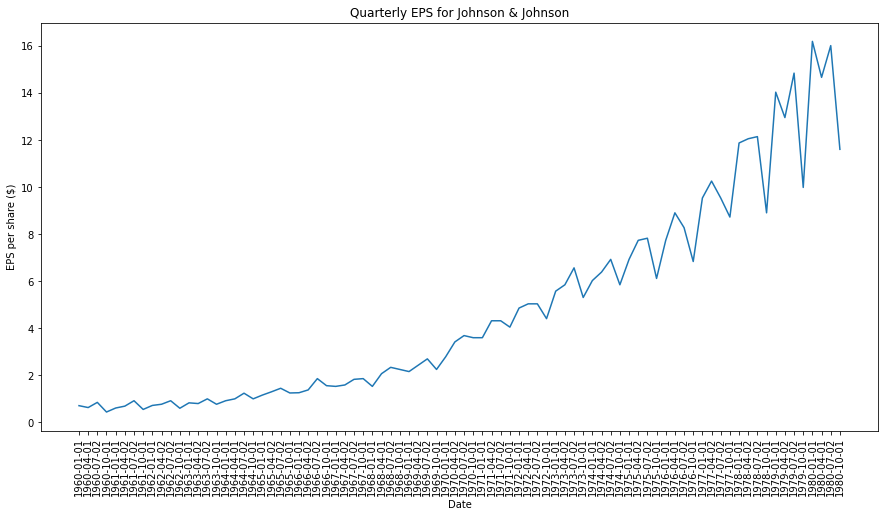

In [6]:
plt.figure(figsize=[15, 7.5])
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

In [7]:
def check_stationarity(series):
    
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

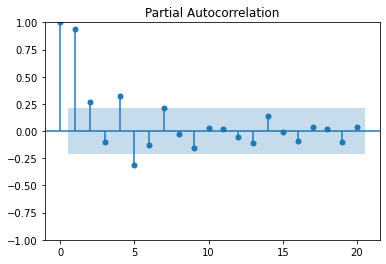

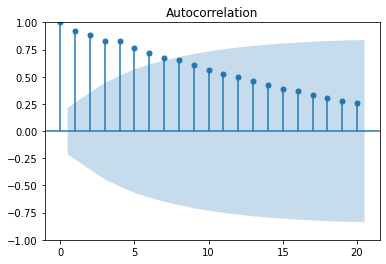

In [8]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [9]:
check_stationarity(data['data'])

ADF Statistic: 2.742017
p-value: 1.000000
Non-stationary


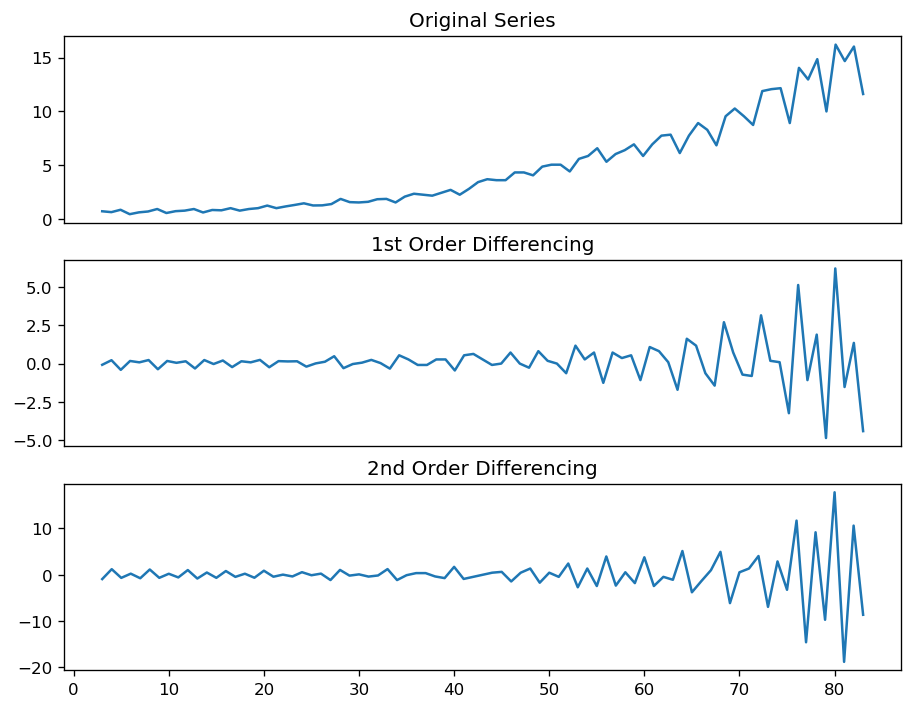

In [10]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.data); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
ax2.plot(data.data.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
ax3.plot(data.data.diff().diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [11]:
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

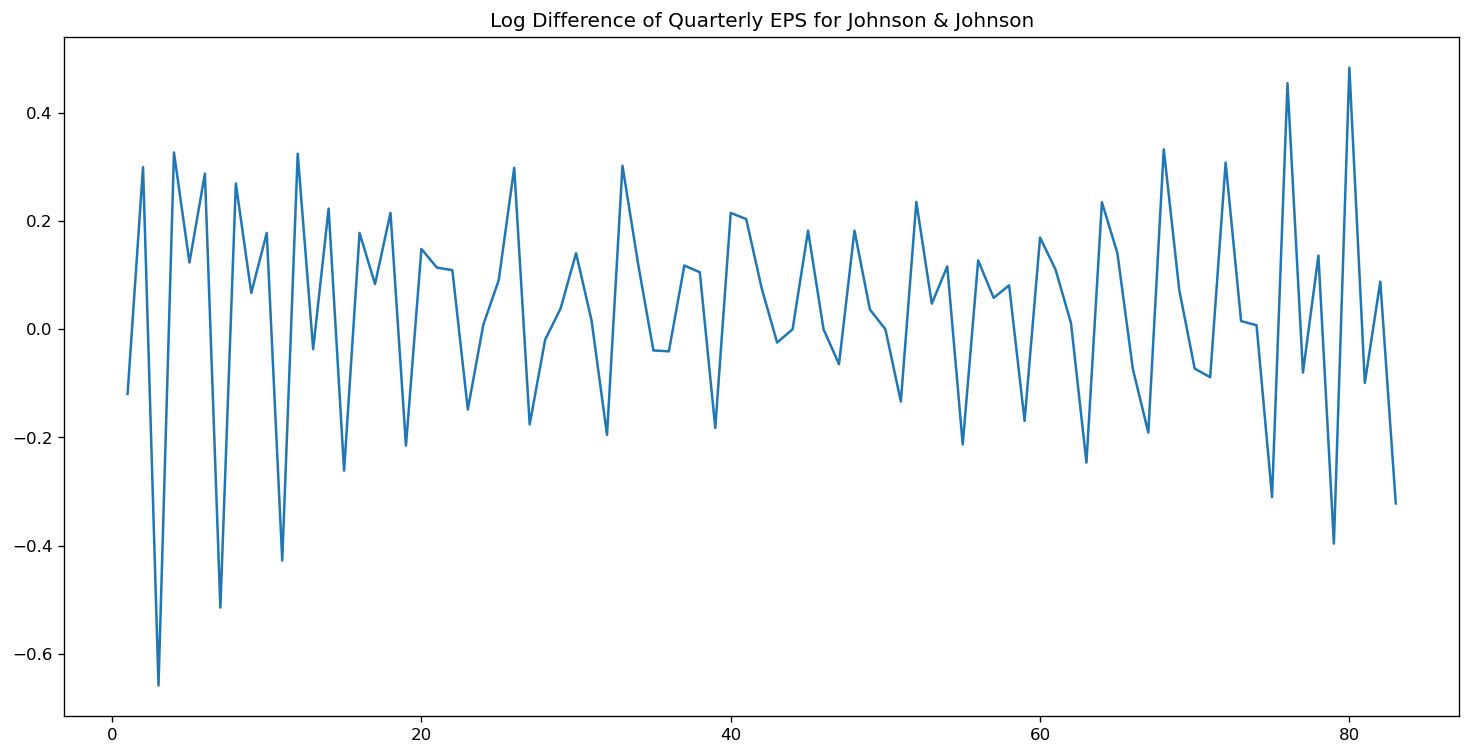

In [12]:
plt.figure(figsize=[15, 7.5])
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [13]:
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)

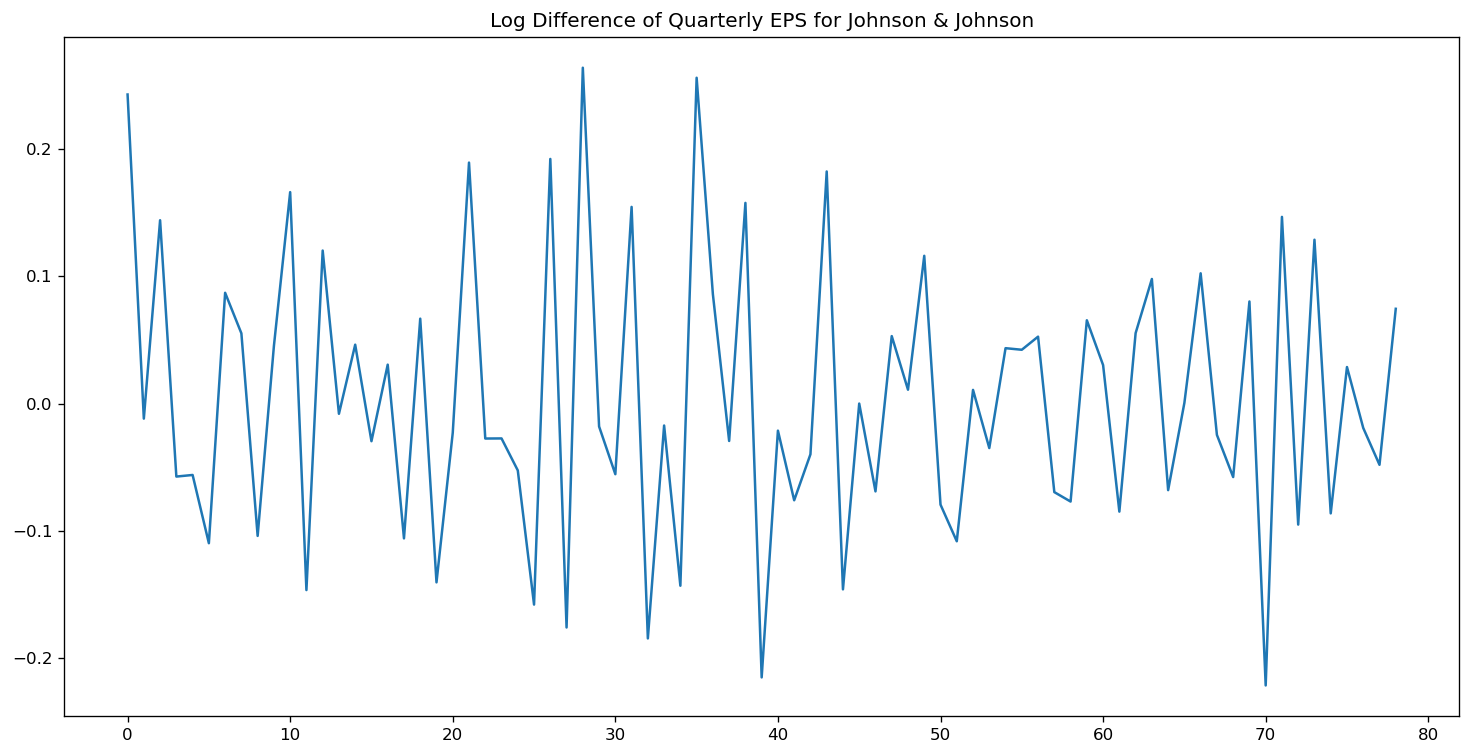

In [14]:
plt.figure(figsize=[15, 7.5])
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [15]:
check_stationarity(data['data'])

ADF Statistic: -6.630805
p-value: 0.000000
Stationary


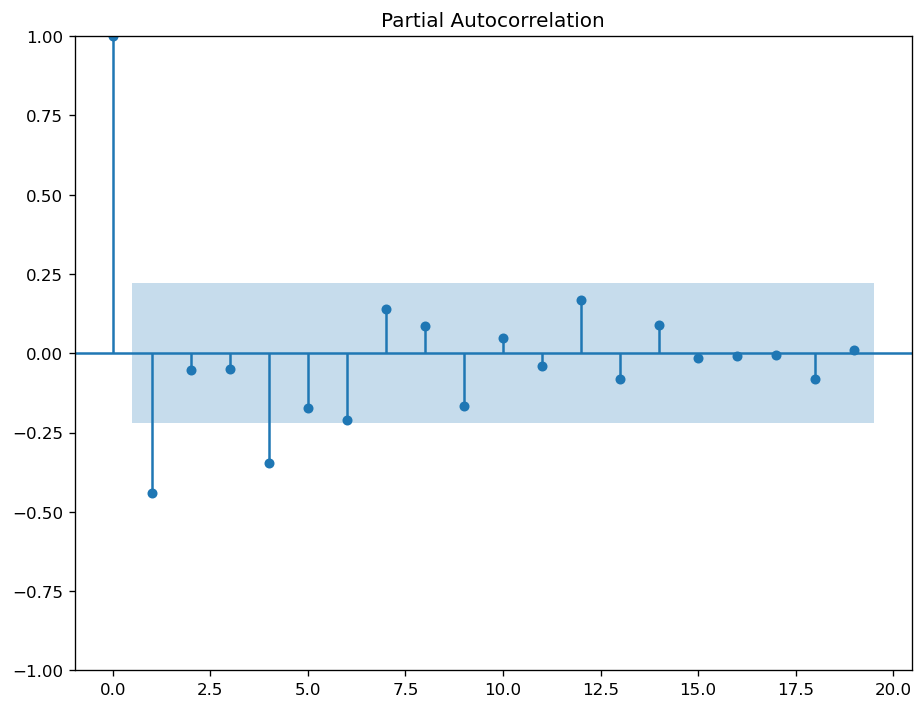

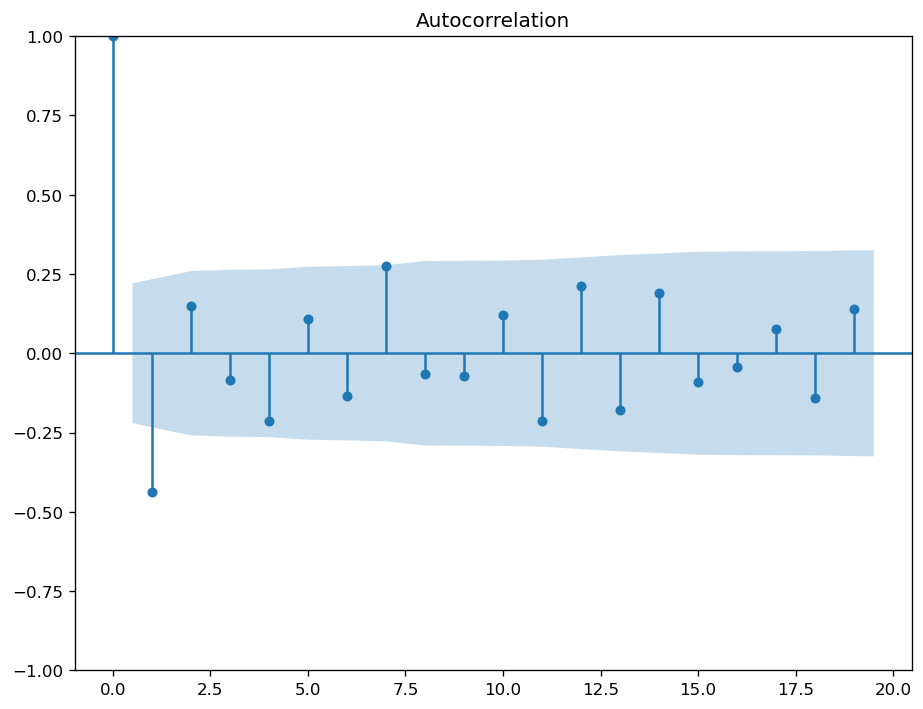

In [16]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [17]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit()
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [26]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [27]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-114.455136
1,"(0, 2, 1, 2)",-114.254482
2,"(0, 2, 1, 3)",-113.519572
3,"(0, 2, 2, 2)",-113.089849
4,"(0, 2, 0, 3)",-113.080106
...,...,...
251,"(0, 0, 1, 1)",-24.752956
252,"(0, 0, 0, 1)",-23.122474
253,"(1, 0, 0, 0)",-19.068827
254,"(0, 0, 1, 0)",2.594264


In [20]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit()
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                   79
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  62.228
Date:                           Mon, 02 Jan 2023   AIC                           -114.455
Time:                                   11:18:00   BIC                           -102.935
Sample:                                        0   HQIC                          -109.860
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5820      0.139    -11.344      0.000      -1.855      -1.309
ma.L2          0.5923      0.112      5.268

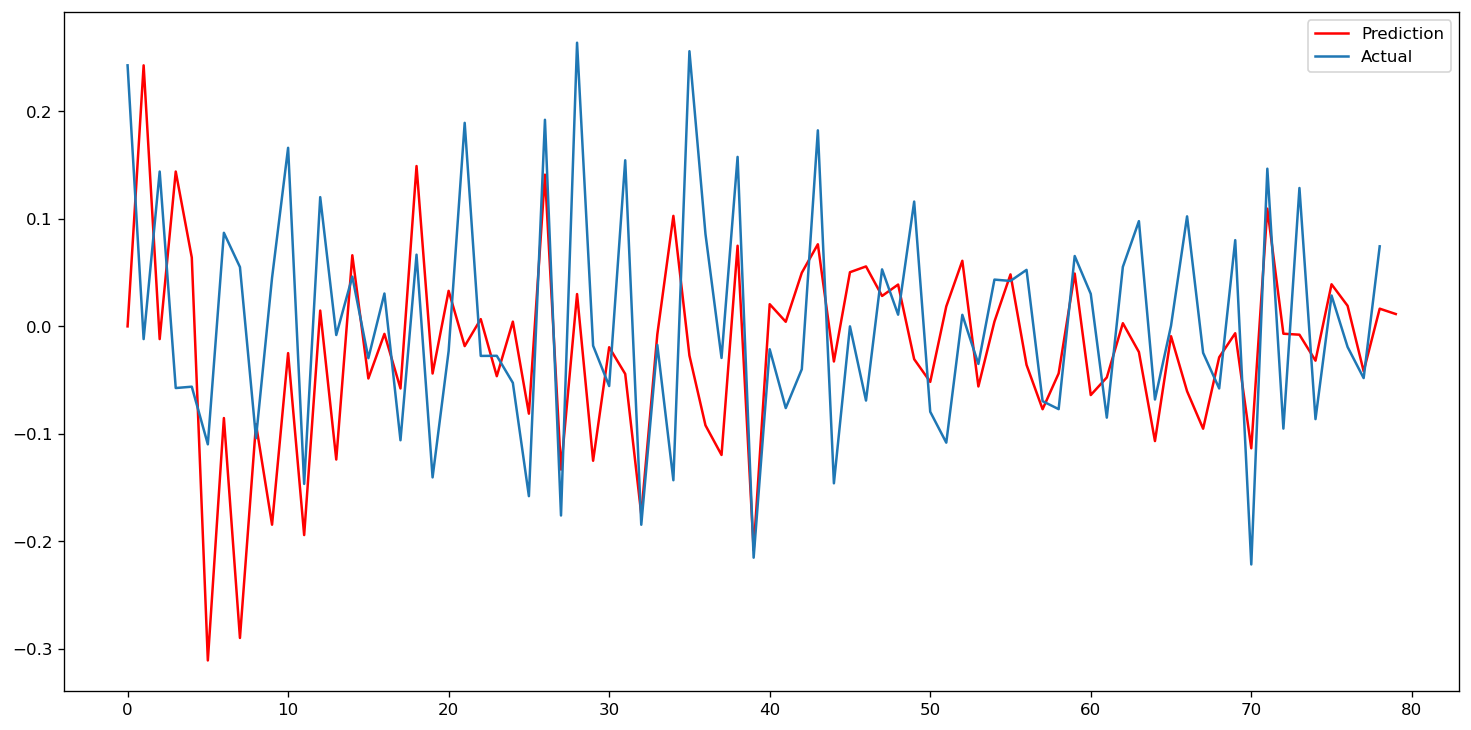

In [23]:
data['arima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=data.shape[0], end=data.shape[0])
forecast = data['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='Prediction')
plt.plot(data['data'], label='Actual')
plt.legend()
plt.show()